<h1><center>Notebook 2 : Stochastic twins generation</center></h1>

<h2>Instructions for this notebook</h2>


This notebook was written by Paul Platzer. It accompanies the following scientific publication:<br>
"Disentangling Density and Geometry in Weather Regime Dimensions using Stochastic Twins"<br>
By Paul Platzer, Bertrand Chapron, and Gabriele Messori.<br>
<b> add doi, date...etc. </b>

It is part of six notebooks that allow to reproduce the figures of the article. It must be used in conjunction with 500mb geopotential height data from ERA5 (last download from october 18th, 2023), as specified in the body text of the article.

What this notebook does:

<ol>
    <li> It opens preprocessed ERA5 data (10day-smoothed anomalies projected on winter-time EOFs) and the results of the GMM fit.</li>
    <li> It inverts the potential that allows for the stochastic twins to have the same distribution as the GMM fit for the three first components.</li>
    <li> It generates stochastic twins of ERA5 smoothed-projected geopotential height anomaly.</li>
    <li> It creates figures to show the outputs of the potential and the stocahstic twins.</li>
    <li> It saves stochastic twin data.</li>
</ol>

To use properly this notebook, you must:

<ol>
    <li> Have previously run "Notebook0-ERA5_pretreatment.ipynb" and "Notebook1-GMM_fit.ipynb".</li>
    <li> Run the whole notebook once.</li>
    <li> If you have already run the notebook, and you just want to replot the figures, you can skip section III., and uncomment the "load" cell in section IV (don't forget to comment the "save" cell). </li>
</ol>

Note that, for this code to work on your machine, you should:

<ol>
    <li> Have download the libraries listed in the first two cells. </li>
    <li> Use python 3 : this code was tested using python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] </li>
    <li> Have enough memory and computing resources. If not, you might have to modify the code to make it work. The code was run using a Dell Inc. Precision 7550 which has 33G of RAM and setting the same amount of swap space, and for processing we have Intel® Core™ i7-10875H CPU @ 2.30GHz × 16, with graphics card NVIDIA Corporation TU104GLM [Quadro RTX 4000 Mobile / Max-Q] / Mesa Intel® UHD Graphics (CML GT2). </li>
</ol>

In [1]:
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import sys
sys.path.append('../functions/.')
# sys.path.append('./')
from functions import density_gmm, potential_gmm, drift_gmm, acf

In [2]:
# list of color-blind-friendly colors
cols = ['k', '#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
data_folder = '../outputs/data/'
figure_folder = '../outputs/figures/'

# I. Load preprocessed ERA5 and GMM parameters

In [4]:
# load
npzfile = np.load(data_folder + 'GMM_params.npz')
means = npzfile['means']
covs = npzfile['covs']
weights = npzfile['weights']
nclus = npzfile['nclus']
cov_type = npzfile['cov_type']
ndim_gmm = npzfile['ndim_gmm']
random_state_gmm = npzfile['random_state_gmm']
regime_names = npzfile['regime_names']
regime_short_names = npzfile['regime_short_names']
regime_attribution = npzfile['regime_attribution']
regime_attribution_distance = npzfile['regime_attribution_distance']
Ndays = npzfile['Ndays']
Ndays_kmeans = npzfile['Ndays_kmeans']
Ndays_tot = npzfile['Ndays_tot']

In [5]:
allpcs = xr.open_dataset(data_folder + 'pcs.nc')['pseudo_pcs']
eofs = xr.open_dataset(data_folder + 'eofs.nc')['eofs']
pourc_EOF = xr.open_dataset(data_folder + 'pourc_eofs.nc')['variance_fractions']

In [6]:
# normalize pcs but keep relative variances
pcs_norm = allpcs / (allpcs.sel(mode=0)).std(dim='time')

# II. Invert potential

So that the distribution of stochastic twins fits the distribution of the ERA5-fitted GMM.

Compute potential and drift.

In [7]:
xx = np.linspace(-3,3,200)
XX, YY, ZZ = np.meshgrid(xx, xx, xx)
pos = np.stack((XX, YY, ZZ), axis=3)

X_, Y_ = np.meshgrid(xx, xx); pos_ = np.dstack((X_, Y_))

V_gm = potential_gmm(pos, means, covs, weights)

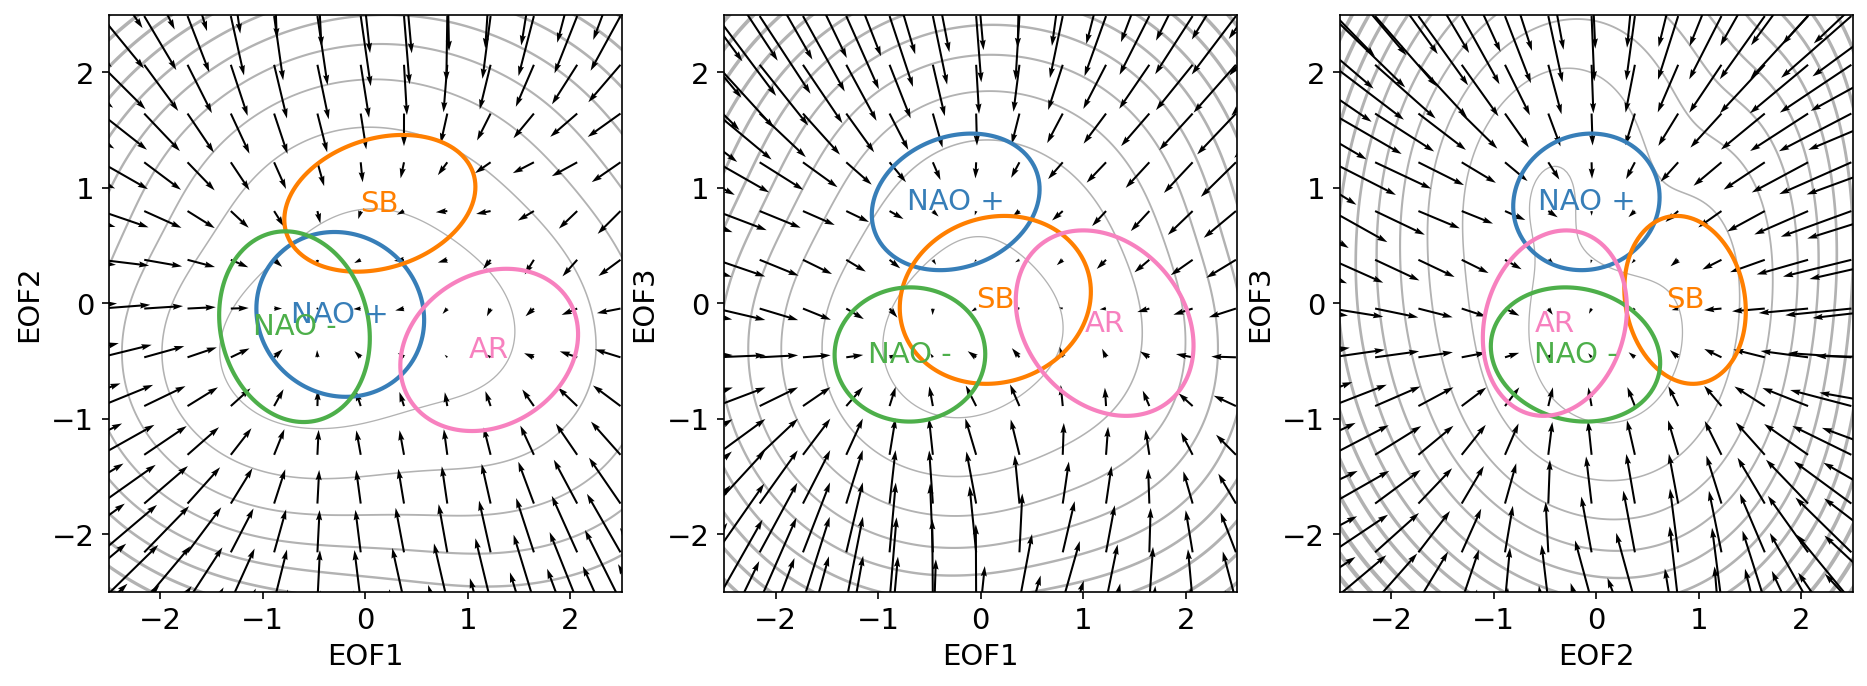

In [13]:
plt.figure(figsize=(15,5), dpi=150)


for i_plot in range(3):
    plt.subplot(131+i_plot)
    
    for i in range(nclus):
        nlevs = 1
        mean_plot = [ means[i,:2] , means[i,:3:2] , means[i,1:3] ][i_plot]
        cov_plot = [ covs[i,:2,:2] , covs[i,:3:2,:3:2] ,
                    covs[i,1:3,1:3] ][i_plot]
        distr = mvn( mean=mean_plot, cov=cov_plot)
        plt.contour( X_, Y_, distr.pdf(pos_),
                    levels = np.max(distr.pdf(pos_))*np.linspace(.5, 1, nlevs+1)[:-1],
                    colors=cols[i+1], linewidths = 2)
        plt.text(mean_plot[0], mean_plot[1], regime_short_names[i],
                 horizontalalignment='center', verticalalignment='center', color=cols[i+1])
    
    nlevs2 = 20
    plt.contour( X_, Y_, np.sum(V_gm, axis=[2,1,0][i_plot]), 
                linewidths = np.linspace(.5, 3, nlevs2), 
                levels = nlevs2, colors = 'k', alpha = .3, zorder = 1 )
    
    
    means_plot = [ means[:,:2] , means[:,:3:2] , means[:,1:3] ][i_plot]
    covs_plot = [ covs[:,:2,:2] , covs[:,:3:2,:3:2] ,
                covs[:,1:3,1:3] ][i_plot]
    
    XX_plot, YY_plot = np.meshgrid(xx, xx)
    pos_plot = np.dstack((XX_plot, YY_plot))
    
    drift_plot = drift_gmm(pos_plot, means = means_plot , covs = covs_plot , weights = weights)
    
    d_arrow = 14
    start = 0; stop = -1
    
    plt.quiver( X_[start:stop:d_arrow,start:stop:d_arrow], Y_[start:stop:d_arrow,start:stop:d_arrow], 
               drift_plot[start:stop:d_arrow, start:stop:d_arrow, 0],
               drift_plot[start:stop:d_arrow, start:stop:d_arrow, 1], scale = 25, cmap='RdGy')
    
    lim = 2.5
    plt.xlim([-lim,lim]); plt.ylim([-lim,lim])
    plt.xlabel(['EOF1','EOF1','EOF2'][i_plot])
    plt.ylabel(['EOF2','EOF3','EOF3'][i_plot])

plt.savefig(figure_folder + 'drift_potential.png', bbox_inches='tight', dpi=150)
plt.show()

# III. Generate data

From SDE defined from potential.

Choose time delta based on visual correspondence of auto-correlation of first principal components with stochastic twin data.

## III.A. First three components.

In [14]:
Ntwins = 20
dt = .08
L = len(pcs_norm)
x = np.zeros( ( Ntwins , L , ndim_gmm ) , dtype='float64' )
for k in tqdm(range(Ntwins)):
#     x0 = .1*np.random.randn( ndim_gmm ) # start at unstable equilibrium
    x0 = 0 # start at unstable equilibrium
    w = np.sqrt(dt) * np.reshape( np.random.randn( ndim_gmm*L ) , ( L , ndim_gmm ) )

    x[k,0] = x0
    for i in tqdm(range(L-1)):
        x[k,i+1] = x[k,i] + drift_gmm(x[k,i], means, covs, weights)*dt + w[i].copy()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

  0%|          | 0/8049 [00:00<?, ?it/s]

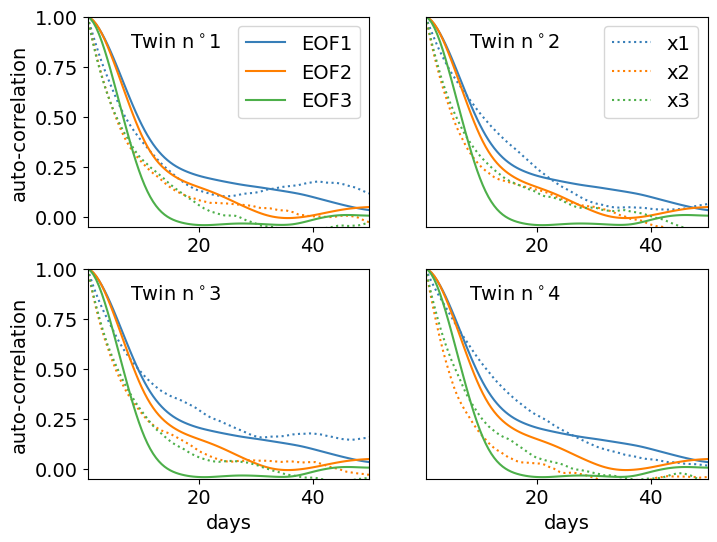

In [16]:
length = 100
plt.figure(figsize=(8,6), dpi=100)
for k in range(min(4,Ntwins)):
    plt.subplot(221+k)
    for i in range(ndim_gmm):
        plt.plot( np.arange(.5 , .5*(length+1), .5) , acf(pcs_norm[:,i], length = length) ,
                 color=cols[i+1] , ls = '-',
                 label= ( 'EOF'+str(i+1) )*( k==0 ) )
        
        plt.plot( np.arange(.5 , .5*(length+1), .5) , acf(x[k,:,i], length = length) ,
                 color=cols[i+1] , ls = ':',
                 label= ( 'x'+str(i+1) )*( k==1 ) )
    plt.text( 8 , 0.85 , r'Twin n$^\circ$'+str(k+1))
    
    if k<2:
        plt.legend()
    plt.ylabel('auto-correlation'*(k==0 or k==2))
    if k==1 or k==3:
        plt.yticks([])
    plt.ylim([-.05,1])
    plt.xlim([.5,.5*length])
    plt.xlabel('days'*(k>1))
plt.savefig(figure_folder + 'autocorr.png', dpi=150, bbox_inches ="tight")
plt.show()

## III.B. Other components.
Simple auto-regressive models (AR1).

$$ x_t = \rho x_{t-1} + \varepsilon_t $$

Where $\varepsilon_t \sim_{i.i.d.} \mathcal{N}(0,1)$

In [19]:
n = 65-ndim_gmm
rho = np.zeros(n, dtype='float64')
for i in range(n):
    rho[i] = acf(allpcs[:,ndim_gmm+i], length=2)[1]
scaling = np.zeros(n, dtype='float64')
for i in range(n):
    scaling[i] = np.sqrt(1-rho[i]**2) * np.sqrt( pourc_EOF[i+ndim_gmm] / pourc_EOF[0] )

In [21]:
xo = np.full( ( Ntwins , L , n ) , np.nan )

for k in tqdm(range(Ntwins)):
    xo0 = 0
    wo = np.reshape(np.random.randn(n*L),(L,n))

    xo[k,0] = xo0
    for i in range(L-1):
        xo[k,i+1] = rho * xo[k,i] + wo[i]
    xo[k] = xo[k]*scaling # /!\ do this only once !

  0%|          | 0/20 [00:00<?, ?it/s]

Merge.

In [23]:
X = np.concatenate( ( x , xo ) , axis = 2 )

# IV. Save
Or load if necessary.

In [26]:
# here to save the data
np.savez(data_folder + 'stoch_twins.npz',
        X = X,
        ndim_gmm = ndim_gmm,
        rho = rho,
        scaling = scaling)

In [20]:
# to load the data
# npzfile = np.load(data_folder + 'stoch_twins.npz')
# X = npzfile['X']
# ndim_gmm = npzfile['ndim_gmm']
# rho = npzfile['rho']
# sig_o = npzfile['sig_o']
# scaling = npzfile['scaling']

# V. Plot

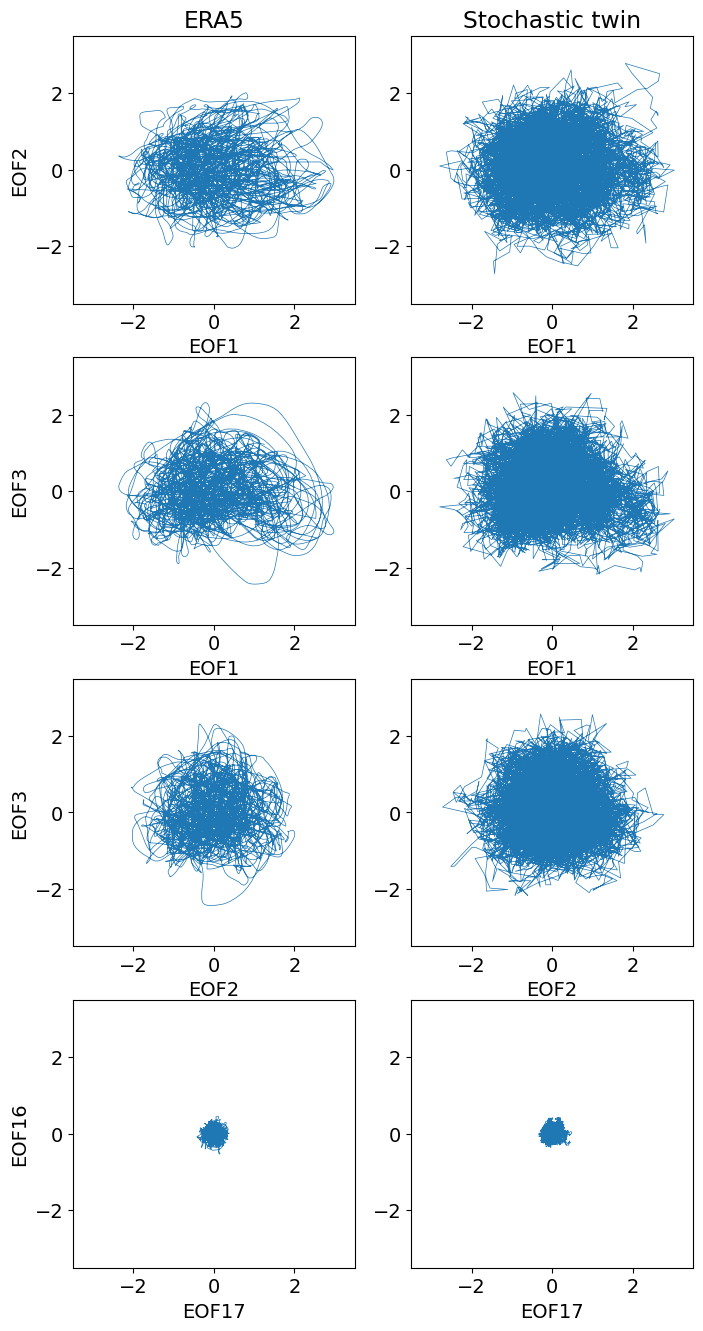

In [25]:
plt.figure(figsize=(8,16))
for i_plot in range(4):
    i_sub = [0,0,1,16][i_plot]
    j_sub = [1,2,2,15][i_plot]
    for j_plot in range(2):
        indplot = [[421,422],[423,424],[425,426],[427,428]][i_plot][j_plot]
        plt.subplot(indplot); 
        plt.plot([pcs_norm,X[0]][j_plot][:,i_sub] , [pcs_norm,X[0]][j_plot][:,j_sub] , lw=.5)
        plt.xlabel('EOF'+str(i_sub+1));
        plt.ylabel(('EOF'+str(j_sub+1))*(j_plot==0));
        border = 3.5
        plt.xlim([-border,border]); plt.ylim([-border,border])
        if i_plot==0:
            plt.title(['ERA5','Stochastic twin'][j_plot])
plt.savefig( figure_folder + 'trajectories_EOFs.png', dpi=150, bbox_inches='tight')
plt.show()